---
title: "Generative AI: Chapter 3"
description: "Variational Autoencoders"
date: "2024-03-06"
# image: "deep_learning_model.png"
categories: [AI, Engineering, GenerativeAI]
format:
  html:
    code-fold: true
---

# Variational Autoencoders
These are notes from chapter 3 of Generative Deep Learning by David Foster.

::: {.callout-tip title="Story Time"}
Imagine an infinite wardrobe organised by "type" of clothing. 

Shoes would be close together, but formal shoes might be closer to the suits and trainers closer to the sports gear. Shirts and t-shirts would be close together. Coats might be nearby; the shirt->coat vector applied to t-shirts might lead you to "invent" gilets.

This encapsulates the idea of using a lower dimensional (2D in this case) latent space to **encode** the representation of more complex objects.

We could *sample* from some of the empty spaces to invent new hybrids of clothing. This generative step is **decoding** the latent space.
:::


## 1. Autoencoders
The idea of autoencoders (read: self-encoders) is that they learn to simplify the input then reconstruct it; the input and target output are the same.

- The **encoder** learns to compress high-dimensional input data into a lower dimensional representation called the *embedding*.
- The **decoder** takes an embedding and recreates a higher-dimensional image. This should be an accurate reconstruction of the input.

This can be used as a generative model because we can the sample and decode *new* points from the latent space to generate novel outputs. The goal of training an autoencoder is to learn a meaningful embedding $z$.


```{mermaid}
flowchart LR

  A(Encoder) --> B(z)
  B(z) --> c(Decoder)
```

This also makes autoencoders useful as *denoising* models, because the embedding should retain the salient information but "lose" the noise.


## 2. Building an Autoencoder
We will implement an autoencoder to learn lower-dimensional embeddings for the [fashion MNIST data set](https://github.com/zalandoresearch/fashion-mnist).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks

# Parameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

### 2.1. Load and pre-process the data
Scale the pixel values and reshape the images.

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

def preprocess(images):
    images = images.astype("float32") / 255.0
    images = np.pad(images, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    images = np.expand_dims(images, -1)
    return images

x_train = preprocess(x_train)
x_test = preprocess(x_test)

We can see an example from our training set:

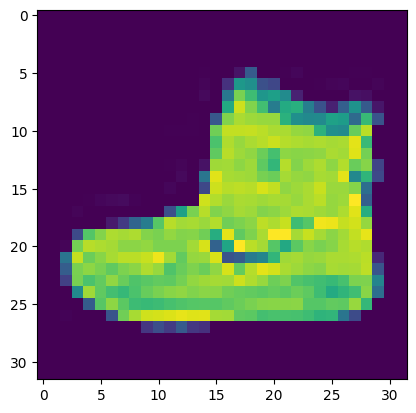

In [3]:
plt.imshow(x_train[0])

### 2.2. Build the Encoder
The encoder compresses the dimensionality on the input to a smaller embedding dimension.

In [4]:
# Input
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),name="encoder_input")

# Conv layers
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
pre_flatten_shape = tf.keras.backend.int_shape(x)[1:]  # Used by the decoder later

# Output
x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

# Model
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

### 2.3. Build the Decoder
The decoder reconstructs the original image from the embedding.

#### Convolutional Transpose Layers
In a standard convolutional layer, if we have `stride=2` it will half the image size.

In a convolutional transpose layer, we are *increasing* the image size. The `stride` parameter determines the amount of zero padding to add between each pixel. A kernel is then applied to this "internally padded" image to expand the image size.

In [5]:
# Input
decoder_input = layers.Input(shape=(EMBEDDING_DIM,),name="decoder_input")

# Reshape the input using the pre-flattening shape from the encoder
x = layers.Dense(np.prod(pre_flatten_shape))(decoder_input)
x = layers.Reshape(pre_flatten_shape)(x)

# Scale up the image back to its original size. These are the reverse of the conv layers applied in the encoder.
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

# Output
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation='sigmoid',
    padding="same",
    name="decoder_output",
)(x)

# Model
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

### 2.4. Build the Autoencoder
Combine the encoder and decoder into a single model.

In [6]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

### 2.5. Train the Autoencoder
The autoencoder is trained with the source images as both input and target output.

The loss function is usually chosen as either RMSE or binary cross-entropy between pixels of original image vs reconstruction.

In [7]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/3


600/600 [==============================] - 35s 58ms/step - loss: 0.2910 - val_loss: 0.2610
Epoch 2/3
600/600 [==============================] - 36s 60ms/step - loss: 0.2569 - val_loss: 0.2561
Epoch 3/3
600/600 [==============================] - 34s 57ms/step - loss: 0.2536 - val_loss: 0.2540


## 3. Analysing the Autoencoder
We can use our trained autoencoder to:

1. Reconstruct images
2. Analyse embeddings
3. Generate new images

### 3.1. Reconstruct Images Using the Autoencoder
Reconstruct a sample of test images using the autoencoder.

The reconstruction isn't perfect; some information is lost when reducing down to just 2 dimensions. But it does a surprisingly good job of compressing 32x32 pixel values into just 2 embedding values.

In [8]:
NUM_IMAGES_TO_RECONSTRUCT = 5000
example_images = x_test[:NUM_IMAGES_TO_RECONSTRUCT]
example_labels = y_test[:NUM_IMAGES_TO_RECONSTRUCT]

predictions = autoencoder.predict(example_images)

  7/157 [>.............................] - ETA: 1s 

157/157 [==============================] - 1s 8ms/step


Original images:

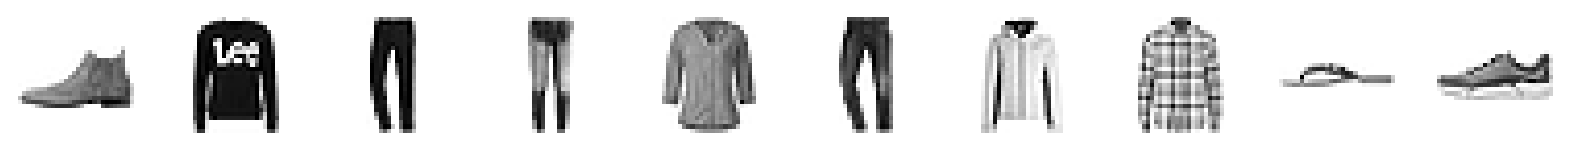

In [9]:
def plot_sample_images(images, n=10, size=(20, 3), cmap="gray_r"):
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype("float32"), cmap=cmap)
        plt.axis("off")
    
    plt.show()

plot_sample_images(example_images)

Reconstructed images:

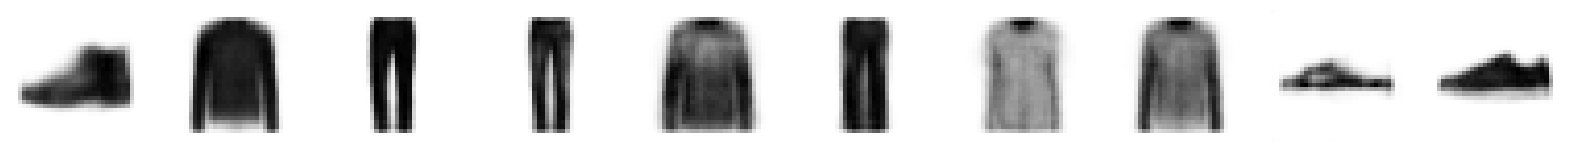

In [10]:
plot_sample_images(predictions)

### 3.2. Analyse the embeddings
Each of the images above has been encoded as a 2-dimensional embedding.

We can look at these embeddings to gain some insight into how the autoencoder works.

The embedding vectors for our sample images above:

In [11]:
# Encode the example images
embeddings = encoder.predict(example_images)
print(embeddings[:10])

102/157 [==================>...........] - ETA: 0s

157/157 [==============================] - 0s 2ms/step
[[ 2.2441912  -2.711683  ]
 [ 6.1558456   6.0202003 ]
 [-3.787192    7.3368516 ]
 [-2.5938551   4.2098355 ]
 [ 3.8645594   2.7229536 ]
 [-2.0130231   6.0485506 ]
 [ 1.2749226   2.1347647 ]
 [ 2.8239484   2.898773  ]
 [-0.48542604 -1.0869933 ]
 [ 0.30643728 -2.6099105 ]]


We can plot the 2D latent space, colouring each point by its label.
This shows how similar items are clustered together in latent space.

This is impressive! Remember, we never showed the model the labels when training, so it has learned to cluster images that look alike.

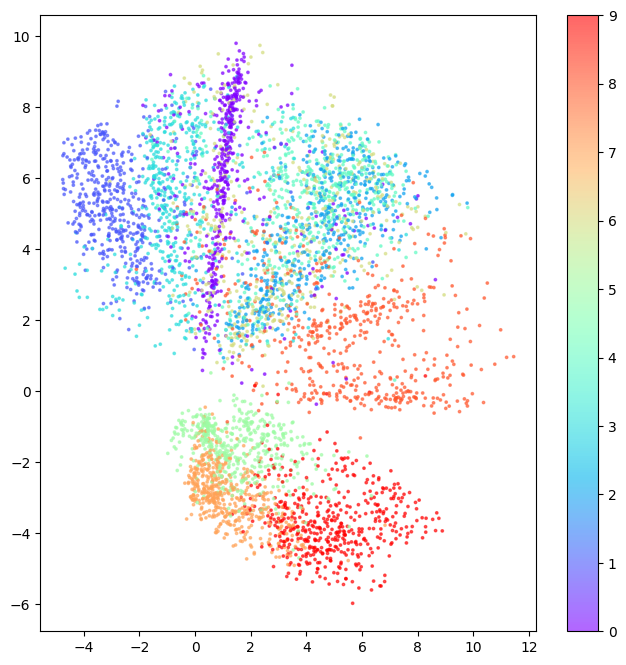

In [12]:
# Colour the embeddings by their label
example_labels = y_test[:NUM_IMAGES_TO_RECONSTRUCT]

# Plot the latent space
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.6,
    s=3,
)
plt.colorbar()
plt.show()

### 3.3. Generating New Images
We can sample from the latent space and decode these sampled points to generate new images.

First we sample some random points in the latent space:

In [13]:
# Get the range of existing embedding values so we can sample sensible points within the latent space.
embedding_min = np.min(embeddings, axis=0)
embedding_max = np.max(embeddings, axis=0)

# Sample some points
grid_width = 6
grid_height = 3
sample = np.random.uniform(
    embedding_min, embedding_max, size=(grid_width * grid_height, EMBEDDING_DIM)
)
print(sample)

[[ 1.47862929  9.28394749]
 [-3.19389344 -3.04713146]
 [-0.57161452 -0.35644389]
 [10.97632621 -2.12482484]
 [ 4.05160668  9.04420005]
 [ 9.50105167  5.71270956]
 [ 3.24765456  4.95969011]
 [-3.68217634  4.52120851]
 [-1.7067196   5.87696959]
 [ 5.99883565 -2.11597183]
 [ 1.84553131  6.04266323]
 [ 0.15552252  1.98655625]
 [ 3.55479856  2.35587959]
 [-0.32278762  6.07537408]
 [ 8.98977414 -1.15893539]
 [ 2.1476981   4.97819188]
 [-2.0896675   3.9166368 ]
 [ 6.49229371 -4.75611412]]


We can then decode these sampled points.

In [14]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 59ms/step


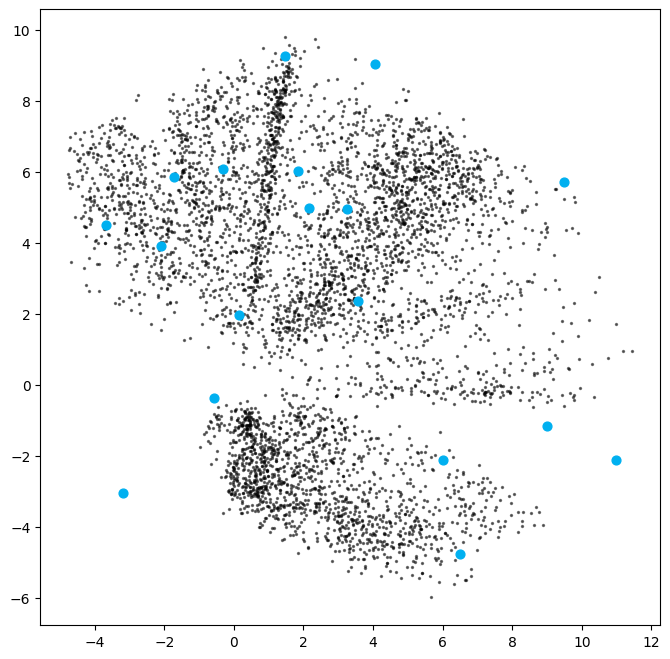

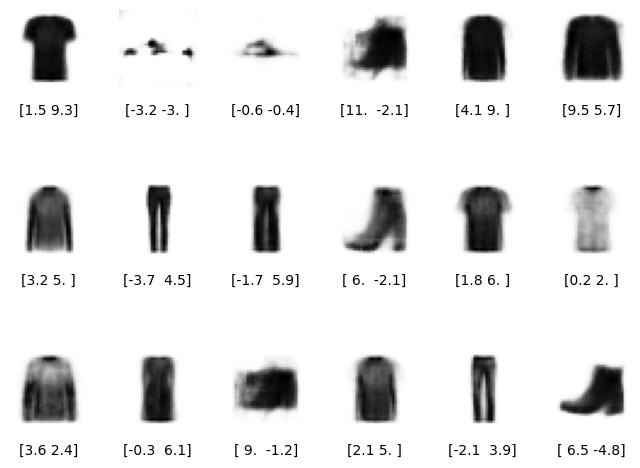

In [15]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# Plot the latent space and overlay the positions of the sampled points
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Plot a grid of the reconstructed images which decode those sampled points
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Now let's see what happens when we regularly sample the latent space.

8/8 [==============================] - 0s 9ms/step


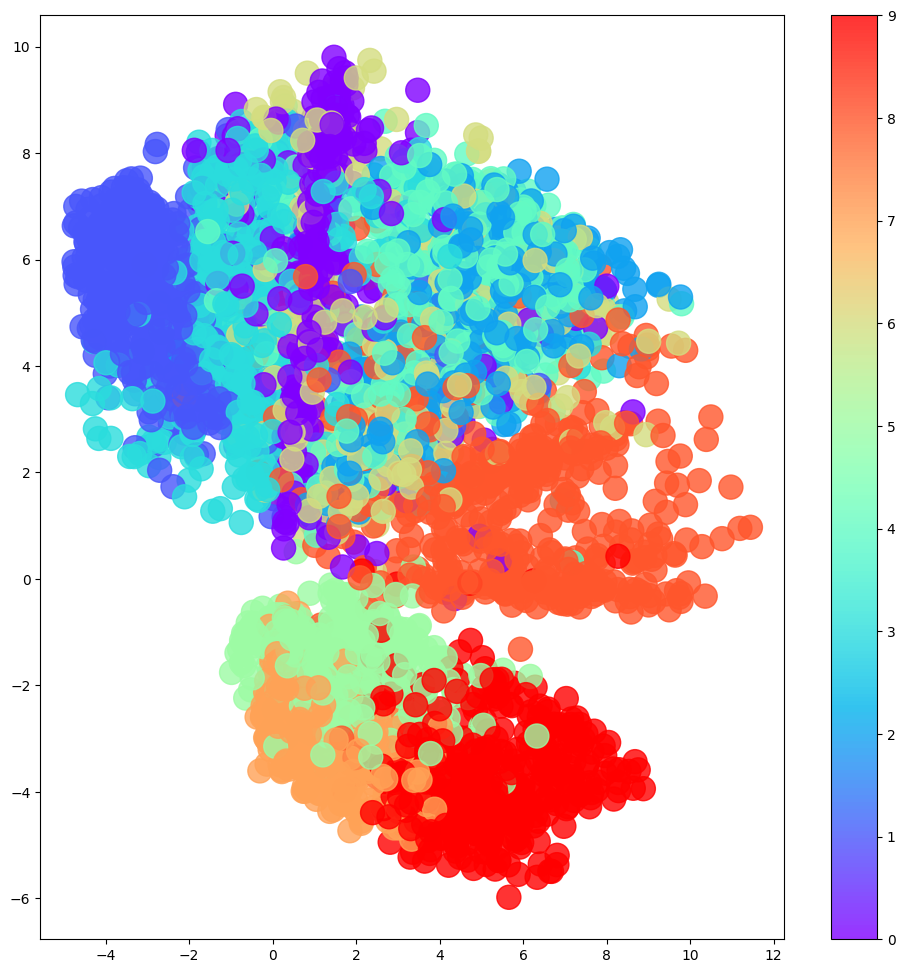

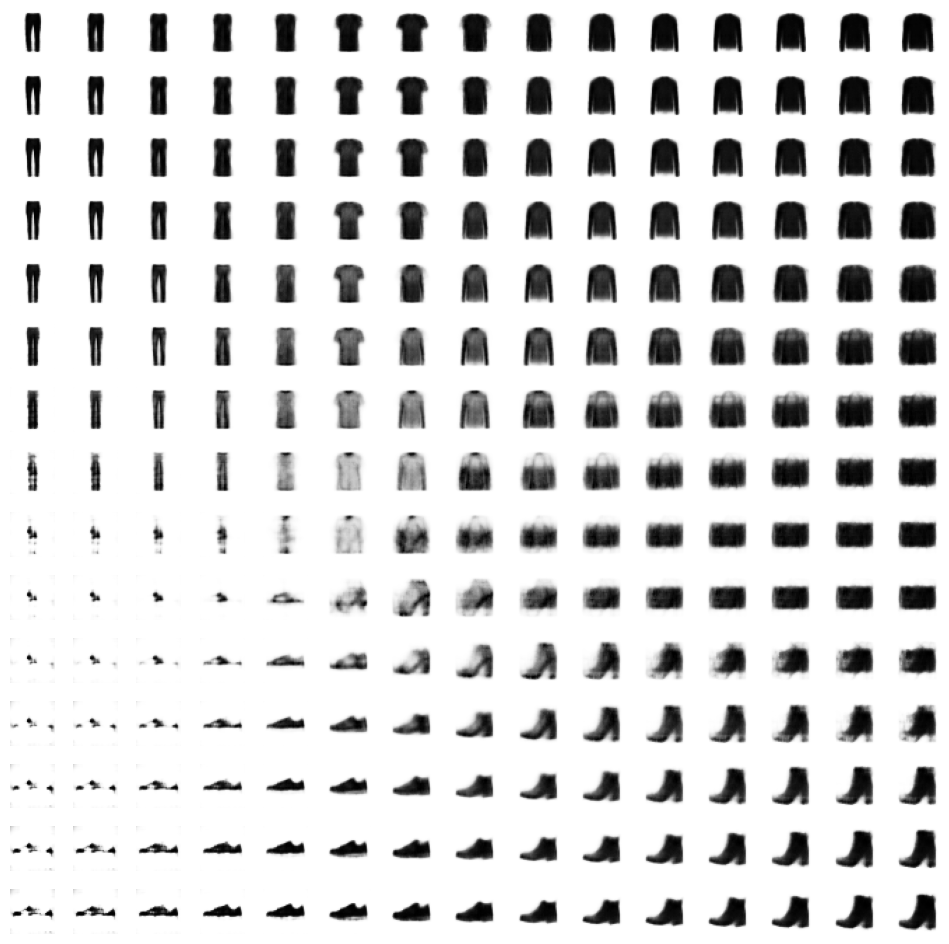

In [16]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

### 3.4. The Limitations of Autoencoders

The latent space exploration above yields some interesting insights into "regular" autoencoders that motivate the use of variational autoencoders to address these shortcomings.

- Different categories occupy varying amounts of area in latent space.
- The latent space distribution is not symmetrical or bounded.
- There are gaps in the latent space.

This makes it difficult for us to sample from this latent space effectively. We could sample a "gap" and get a nonsensical image. If a category (say, trousers) occupies a larger area in latent space, we are more likely to generate images of trousers than of categories which occupy a small area (say, shoes).

## 4. Variational Autoencoders

::: {.callout-tip title="Story Time"}
If we revisit our wardrobe, rather than assigning each item to a specific location, let's assign it to a general *region* of the wardrobe.

And let's also insist that this region should be as close to the centre of the wardrobe as possible, otherwise we are penalised.
This should yield a more uniform latent space.

This is the idea behind **variational autoencoders** (VAE).
:::


### 4.1. The Encoder

In a standard autoencoder, each image is mapped directly to **one point** in the latent space.

In a *variational* autoencoder, each image is mapped to a multivariate Normal distribution **around a point** in the latent space.
Variational autoencoders assume their is no correlation between latent space dimensions.

So we will typically use *isotropic* Normal distributions, meaning the covariance matrix is diagonal so the distribution is independent in each dimension. The encoder only needs to map each input to a mean vector and a variance vector; it does not need to worry about covariances.

In practice we choose to map to *log variances* because this can be any value in the range $(-\infty, \infty)$ which gives a smoother value to learn rather than variances whihc are positive.

In summary, the encoder maps $image \rightarrow (z_{mean}, z_{log\_var})$

We can then **sample** a point $z$ from this distribution using:

$$
z = z_{mean} + z_{sigma} * epsilon
$$

where:
$$
z_{sigma} = e^{z_{log\_var} * 0.5}
$$
$$
epsilon \sim \mathcal{N}(0, I)
$$

### 4.2. The Decoder

This is identical to the standard autoencoder.


### 4.3. The Variational Autoencoder

Putting these together, we get the overall architecture:

```{mermaid}
flowchart LR


  A[Encoder] --> B1(z_mean)
  A[Encoder] --> B2(z_log_var)

  B1(z_mean) --> C[sample]
  B2(z_log_var) --> C[sample]

  C[sample] --> D(z)
  D(z) --> E[Decoder]
```

Why does this change to the encoder help?

In the standard autoencoder, there is no requirement for the latent space to be continuous. So we could sample a point, say, $(1, 2)$ and decode it to a well-formed image. But there is no guarantee that a point next to it $(1.1, 2.1)$ would look similar or even be intelligible.

The "variational" part of the VAE addresses this problem. We now sample from an area around z_mean, so the decoder must ensure that all points in that region produce similar images to keep the reconstruction loss small.


## 5. Building a Variational Autoencoder (VAE)

### Reparameterization trick
Rather than sample directly from a Normal distribution parameterised by z_mean and z_log_var, we can sample epsilon from a standard Normal distribution and manually adjust the sample to correct its mean and variance.

This means gradients can backpropagate freely through the layer. The randomness in the layer is all encapsulated in epsilon, so the partial derivative of the layer output w.r.t. the layer input is deterministic, making backpropagation possible.

### The loss function

The loss function of the standard autoencoder was the reconstruction loss between original image and its decoded version.

For VAEs, we add an additional term which encourages points to have small mean and variance.

This is the Kullback-Leibler (KL) divergence.
It measures how much one probability distribution differs from another. We use it to measure how much our Normal distribution, with parameters z_mean and z_log_var, differs from a standard Normal distribution.

## 